In [101]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import sys
from ipywidgets import widgets
from IPython.display import display, HTML
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from tabulate import tabulate
import math

# Customized modules
HOME = '/home/serinatan/project/GPU-Virtualization-Benchmarks/util'
if HOME not in sys.path:
    sys.path.append(HOME)

import data.scripts.common.format as fmt
import data.scripts.common.constants as const
import data.scripts.gen_tables.gen_pair_configs as gen_pair
import data.scripts.gen_tables.search_best_inter as search_inter
import data.scripts.gen_graphs.gen_altair_timeline as gen_altair
import scheduler.scheduler as scheduler
import data.scripts.gen_tables.gen_lut_configs as lut_configs

SCRIPT_PATH = os.path.join(HOME, 'data/scripts') 
PKL_PATH = os.path.join(HOME, 'data/pickles') 
CSV_PATH = os.path.join(HOME, 'data/csv') 
GRAPH_PATH = os.path.join(HOME, 'data/graphs')

%config InlineBackend.figure_format ='retina'
plt.style.use('seaborn-talk')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
def draw_table(df, cols, hide_index=True):
    if hide_index:
        return df[cols].style.set_table_styles(fmt.table_style).hide_index()
    else:
        return df[cols].style.set_table_styles(fmt.table_style)

# Seq

In [104]:
# run python scripts to generate all the pickles needed
gen_seq = os.path.join(SCRIPT_PATH, 'gen_tables/gen_table_seq.py')   
seq_file = os.path.join(CSV_PATH, 'seq-multi.csv')
seq_pkl = os.path.join(PKL_PATH, 'seq-multi.pkl')
%run $gen_seq --csv $seq_file --output $seq_pkl

df_seq = pd.read_pickle(os.path.join(PKL_PATH, 'seq-multi.pkl'))
print(df_seq.columns)

Index(['pair_str', 'config', 'gpusim_version', 'jobId', 'tot_runtime',
       'stall_icnt_to_l2', 'stall_l2_to_icnt', 'stall_core_ldst',
       'l1D_miss_rate', 'l2_miss_rate', 'l2_rshr_entry_fail',
       'l2_rshr_merge_fail', 'l2_total_accesses', 'mem_count', 'empty_warp',
       'stall_warp', 'idle_warp', 'scoreboard_warp', 'tot_warp_insn',
       'sp_busy', 'dp_busy', 'int_busy', 'tensor_busy', 'sfu_busy', 'runtime',
       'instructions', 'l2_bw', 'barrier_cycles', 'inst_empty_cycles',
       'branch_cycles', 'scoreboard_cycles', 'stall_sp_cycles',
       'stall_dp_cycles', 'stall_int_cycles', 'stall_tensor_cycles',
       'stall_sfu_cycles', 'stall_mem_cycles', 'not_selected_cycles',
       'cycles_per_issue', 'avg_mem_lat', 'avg_core_to_l2', 'avg_l2_to_core',
       'avg_mrq_latency', 'dram_eff', 'dram_bw', 'row_buffer_locality',
       'mem_idle', 'total_cmd', 'ipc', 'avg_dram_bw', 'avg_dram_eff',
       'avg_row_locality', 'std_dram_bw', 'ratio_dram_bw', 'MPKI',
       'l2_acc

In [105]:
col_seq = ['pair_str', '1_kidx', 'runtime', 'instructions',
           'ipc',
           'avg_dram_bw', 
           'waves',
           'l1D_miss_rate',
           'l2_miss_rate',
          ]

draw_table(df_seq, col_seq).format({
    'runtime': '{:,}',
    'instructions': '{:,}',
    'avg_dram_bw':'{:.4f}', 
    'sp_busy': '{:.2f}',
    'dp_busy': '{:.2f}',
    'int_busy': '{:.2f}',
    'tensor_busy': '{:.2f}',
    'sfu_busy': '{:.2f}',
})

pair_str,1_kidx,runtime,instructions,ipc,avg_dram_bw,waves,l1D_miss_rate,l2_miss_rate
nvd_conv-0,1,"165,836","405,798,912",2446.99,0.5563,7.2,0.9996,0.8916
nvd_conv-0,2,"145,524","365,518,848",2511.74,0.6369,14.4,0.9996,0.8952
parb_mriq-0,1,"1,572","45,056",28.6616,0.0003,0.0125,1,0.3292
parb_mriq-0,2,"3,216,469","21,735,183,780",6757.47,0.0009,1.6,0.7154,0.238
parb_sad-0,1,"105,844","138,709,296",1310.51,0.0000,1.16471,0.9999,0.6139
parb_sad-0,2,"17,627","4,380,156",248.491,0.3181,0.0773438,0.9118,0.985
parb_sad-0,3,"14,042","1,151,370",81.9947,0.0806,0.0386719,0.9109,0.9371
parb_sad-1,1,"5,036,523","11,264,876,160",2236.64,0.0728,94.5882,0.9999,0.6768
parb_sad-1,2,"1,760,037","355,721,760",202.11,0.5247,6.28125,0.9142,0.9996
parb_sad-1,3,"377,600","93,505,200",247.63,0.5556,3.14062,0.9123,0.999


# Intra

In [114]:
gen_intra = os.path.join(SCRIPT_PATH, 'gen_tables/gen_table_intra.py')
intra_file = os.path.join(CSV_PATH, 'intra-multi.csv')
intra_pkl = os.path.join(PKL_PATH, 'intra-multi.pkl')

%run $gen_intra --out_intra $intra_pkl --seq $seq_pkl --csv $intra_file

df_intra = pd.read_pickle(intra_pkl)
df_intra.sort_values(['pair_str', '1_kidx'], inplace=True)
# col_intra = ['pair_str', '1_kidx', 'regs', 'thread_count', 'smem', 'intra']
# draw_table(df_intra, col_intra)

In [115]:
col_prod = ['pair_str_x', '1_kidx_x', 'pair_str_y', '1_kidx_y',
            'norm_ipc_x', 'norm_ipc_y', 'diff_mflat', 'sum_ipc', 
            'intra_x', 'intra_y', 
           'sum_comp', 'sum_dram',]
find_pair = os.path.join(SCRIPT_PATH, 'gen_tables/gen_pair_configs.py')
pairs = df_seq.apply(lambda row: ':'.join([row['pair_str'], str(row['1_kidx'])]), axis=1)

In [116]:
app1 = widgets.Dropdown(options=pairs, value=pairs[0], description='App 1:')
app2 = widgets.Dropdown(options=pairs, value=pairs[1], description='App 2:')
intra_out = widgets.Output()

qos = widgets.FloatSlider(
    value=0.75,
    min=0.1,
    max=0.95,
    step=0.05,
    description='QoS:',
    readout_format='.2f',
)

button = widgets.Button(description='Calculate', button_style='info')

def show_widgets_intra():
    display(app1)
    display(app2)
    display(qos)
    display(button)
    

def onclick(b):
    intra_out.clear_output()
#     show_widgets_intra()

    with intra_out:
        %run $find_pair --app $app1.value $app2.value --qos $qos.value --intra_pkl $intra_pkl --top

        df_prod = pd.read_pickle(os.path.join(PKL_PATH, 'pair_candidates.pkl'))
        display(HTML(draw_table(df_prod, col_prod, False).render()))

button.on_click(onclick)
widgets.VBox([app1, app2, qos, button, intra_out])


# CTA LUT

In [57]:
lut_csv = os.path.join(HOME, 'data/csv/pair_lut.csv')
lut_out = os.path.join(PKL_PATH, 'pair_lut.pkl')

%run $gen_pair --csv $lut_csv --output $lut_out --seq_pkl $seq_pkl --multi --how lut

Index(['pair_str', 'config', 'gpusim_version', 'jobId', 'tot_runtime',
       'stall_icnt_to_l2', 'stall_l2_to_icnt', 'stall_core_ldst',
       'l1D_miss_rate', 'l2_miss_rate', 'l2_rshr_entry_fail',
       'l2_rshr_merge_fail', 'l2_total_accesses', 'mem_count', 'empty_warp',
       'stall_warp', 'idle_warp', 'scoreboard_warp', 'tot_warp_insn',
       'runtime', 'instructions', 'l2_bw', 'avg_mem_lat', 'avg_core_to_l2',
       'avg_l2_to_core', 'avg_mrq_latency', 'dram_eff', 'dram_bw',
       'row_buffer_locality', 'mem_idle', 'total_cmd'],
      dtype='object')


In [58]:
df_lut = pd.read_pickle(lut_out)
col_lut = ['pair_str', '1_bench', '2_bench', 'norm_ipc', 'runtime'] 
# draw_table(df_lut, col_lut)

# Pair-Dynamic

In [9]:
gen_pair = os.path.join(SCRIPT_PATH, 'gen_tables/gen_table_pair.py')
dynamic_csv = os.path.join(CSV_PATH, 'pair_dynamic_multi.csv')
dynamic_output = os.path.join(PKL_PATH, 'pair_dynamic_multi.pkl')
%run $gen_pair --csv $dynamic_csv --output $dynamic_output --seq_pkl $seq_pkl --qos 0.5 --how dynamic --multi --isolated_pkl $intra_pkl

Index(['pair_str', 'config', 'gpusim_version', 'jobId', 'tot_runtime',
       'stall_icnt_to_l2', 'stall_l2_to_icnt', 'stall_core_ldst',
       'l1D_miss_rate', 'l2_miss_rate', 'l2_rshr_entry_fail',
       'l2_rshr_merge_fail', 'l2_total_accesses', 'mem_count', 'empty_warp',
       'stall_warp', 'idle_warp', 'scoreboard_warp', 'tot_warp_insn',
       'runtime', 'instructions', 'l2_bw', 'avg_mem_lat', 'avg_core_to_l2',
       'avg_l2_to_core', 'avg_mrq_latency', 'dram_eff', 'dram_bw',
       'row_buffer_locality', 'mem_idle', 'total_cmd'],
      dtype='object')


In [10]:
df_dynamic = pd.read_pickle(dynamic_output)
col_dynamic = ['1_bench', '1_kidx', '1_intra', '2_bench', '2_kidx', '2_intra', 'sld', 'ws', 'runtime',
               'importance', 'weighted_increase', 'sum_increase']

df_dynamic_show = df_dynamic[(df_dynamic['1_bench'] == 'parb_sad-0') & \
                             (df_dynamic['2_bench'] == 'rod_cfd-0') & \
                             (df_dynamic['1_kidx'] == 2) & \
                             (df_dynamic['2_kidx'] == 6) \
                            ]
df_dynamic_show[col_dynamic]

,1_bench,1_kidx,1_intra,2_bench,2_kidx,2_intra,sld,ws,runtime,importance,weighted_increase,sum_increase
23,parb_sad-0,2,2.0,rod_cfd-0,6,4.0,"[0, 0.5069256637584366, 0.7780431177446103]",1.284969,"[[], [42523], [15075, 27838]]","[0, 0.2506657363800221, 0.055307209883529024]","[0, 0.4944822373393802, 0.07108501909746781]",0.565567
54,parb_sad-0,2,2.0,rod_cfd-0,6,2.0,"[0, 0.5801173367780827, 0.49015838522295124]",1.070276,"[[], [37158], [23929, 19599]]","[0, 0.2506657363800221, 0.055307209883529024]","[0, 0.4320948892377464, 0.11283538454283963]",0.544930
59,parb_sad-0,2,2.0,rod_cfd-0,6,3.0,"[0, 0.5076658580815336, 0.676998556998557]",1.184664,"[[], [42461], [17325, 26721]]","[0, 0.2506657363800221, 0.055307209883529024]","[0, 0.49376126518983665, 0.08169472344037346]",0.575456
70,parb_sad-0,2,1.0,rod_cfd-0,6,1.0,"[0, 0.4944036697247706, 0.37040896889309965]",0.864813,"[[], [43600], [31665, 20017]]","[0, 0.2506657363800221, 0.055307209883529024]","[0, 0.5070062212919356, 0.14931390578582543]",0.656320
73,parb_sad-0,2,2.0,rod_cfd-0,6,5.0,"[0, 0.5017340502292671, 0.6183735336760248]",1.120108,"[[], [42963], [13243, 24692, 13663]]","[0, 0.2506657363800221, 0.055307209883529024]","[0, 0.49959881388452815, 0.08943980761069459]",0.589039
75,parb_sad-0,2,2.0,rod_cfd-0,6,1.0,"[0, 0.6163083257090577, 0.3325206248405296]",0.948829,"[[], [34976, 20482.83581841575], [35273]]","[0, 0.2506657363800221, 0.055307209883529024]","[0, 0.4067213210070353, 0.1663271561276937]",0.573048


In [11]:
df_seq_index = df_seq.set_index(['pair_str', '1_kidx'])
df_intra_index = df_intra.set_index(['pair_str', '1_kidx', 'intra'])

In [96]:
dynamic_out = widgets.Output()    

def best_onclick(b):
    dynamic_out.clear_output()
    show_widgets_best()
    
    # apps = best_dd.value.split('+')
    apps = re.split(r'-(?=\D)', best_dd.value)
           
    # Output LUT resource configuration 
    weighted = (best_type_dd.value == 'Global (weighted)')
    
    with dynamic_out:
        # Prediction
        configs, interference = lut_configs.get_lut_matrix(apps, df_dynamic, weighted)

        headers = [const.gen_kernel_headers(apps[0]), const.gen_kernel_headers(apps[1])]

        lut_configs.pretty_print_matrix(apps, 'configs', configs, headers)
#         lut_configs.pretty_print_matrix(apps, 'slowdown', interference, headers)
        print('\n')

        lut_configs.print_rsrc_usage(configs, headers, df_intra_index)
        print('\n')

        # Run simulation to predict final slowdown
        scaled_runtime, norm_ipc = lut_configs.predict_app(apps, interference, df_seq_index)

        row = pd.Series({'1_bench': apps[0], '2_bench': apps[1], 
                         'runtime': scaled_runtime, 'norm_ipc': norm_ipc})

        gen_altair.draw_timeline_from_metrics(row, title='Prediction').display()  
        
        # LUT results
        row = df_lut[(df_lut['1_bench'] == apps[0]) & (df_lut['2_bench'] == apps[1])].iloc[0]

        print('-' * 100)
        print('slowdown:', row['sld'])
        print('weighted speedup:', row['ws'])

        gen_altair.draw_timeline_from_metrics(row, title='CTA LUT').display()  


best_dd = widgets.Dropdown(options=df_dynamic['pair_str'].unique(), description='Pair:')
best_type_dd = widgets.Dropdown(options=['Local', 'Global (weighted)'], value='Global (weighted)', description='Type')
best_btn = widgets.Button(description='Best', button_style='info')

best_btn.on_click(best_onclick)
widgets.VBox([best_dd, best_type_dd, best_btn, dynamic_out])


# CTX Ratio

In [13]:
ctx_csv = os.path.join(HOME, 'data/csv/ctx.csv')
output = os.path.join(PKL_PATH, 'pair_ctx.pkl')


In [14]:
%run $gen_pair --csv $ctx_csv --output $output --seq_pkl $seq_pkl --qos 0.5 --multi --how ctx

Index(['pair_str', 'config', 'gpusim_version', 'jobId', 'tot_runtime',
       'stall_icnt_to_l2', 'stall_l2_to_icnt', 'stall_core_ldst',
       'l1D_miss_rate', 'l2_miss_rate', 'l2_rshr_entry_fail',
       'l2_rshr_merge_fail', 'l2_total_accesses', 'mem_count', 'empty_warp',
       'stall_warp', 'idle_warp', 'scoreboard_warp', 'tot_warp_insn',
       'runtime', 'instructions', 'l2_bw', 'avg_mem_lat', 'avg_core_to_l2',
       'avg_l2_to_core', 'avg_mrq_latency', 'dram_eff', 'dram_bw',
       'row_buffer_locality', 'mem_idle', 'total_cmd'],
      dtype='object')


In [15]:
df_ctx= pd.read_pickle(output)
uniq_pairs = df_ctx[['1_bench', '2_bench']].drop_duplicates().values
uniq_pairs = ['+'.join(x) for x in uniq_pairs]

col_ctx = ['1_bench', '2_bench', '1_ctx', '2_ctx', 
           'cta_quota',
#            'runtime', 'norm_runtime'
          ]
draw_table(df_ctx, col_ctx)

1_bench,2_bench,1_ctx,2_ctx,cta_quota
parb_mriq-0,parb_sad-1,0.25,0.75,"[[], [1, 2, 2], [12, 12, 24]]"
parb_mriq-0,parb_sad-1,0.75,0.25,"[[], [1, 6, 6], [4, 4, 8]]"
parb_mriq-0,parb_sad-1,0.5,0.5,"[[], [1, 4, 4], [8, 8, 16]]"
parb_sad-0,rod_cfd-0,0.75,0.25,"[[], [12, 2, 2], [4, 4, 4, 2, 2, 2, 2, 2, 2, 2]]"
parb_sad-0,rod_cfd-0,0.25,0.75,"[[], [4, 2, 2], [10, 10, 10, 7, 6, 5, 6, 5, 6, 5]]"
parb_sad-0,rod_cfd-0,0.5,0.5,"[[], [8, 2, 2], [8, 8, 8, 5, 4, 4, 4, 4, 4, 4]]"
parb_sad-0,parb_sad-1,0.5,0.5,"[[], [8, 2, 2], [8, 8, 16]]"
parb_sad-0,parb_sad-1,0.25,0.75,"[[], [4, 2, 2], [12, 12, 24]]"
parb_sad-0,parb_sad-1,0.75,0.25,"[[], [12, 2, 2], [4, 4, 8]]"
parb_mriq-0,rod_cfd-0,0.25,0.75,"[[], [1, 2, 2], [10, 10, 10, 7, 6, 5, 6, 5, 6, 5]]"


In [16]:
df_dynamic_index = df_dynamic.set_index(['1_bench', '1_kidx', '1_intra', '2_bench', '2_kidx', '2_intra'])

In [97]:
ctx_dd = widgets.Dropdown(options=uniq_pairs, value=uniq_pairs[0], description='Pair:')
ctx_btn = widgets.Button(description='Display', button_style='info')
out = widgets.Output()

def show_widgets_ctx():
    display(ctx_dd)
    display(ctx_btn)
    

def ctx_onclick(b):
    out.clear_output()
    show_widgets_ctx()
    
    apps = ctx_dd.value.split('+')
    df_apps = df_ctx[(df_ctx['1_bench'] == apps[0]) & (df_ctx['2_bench'] == apps[1])]
    df_apps = df_apps.sort_values('1_ctx')
    
    with out:
        for rid, row in df_apps.iterrows():
            # Show actual timeline
            gen_altair.draw_timeline_from_metrics(row, col_title='1_ctx').display()  
            # Print ctas/SM for each kernel in each app
            print(apps[0], ':', row['cta_quota'][1], 'CTAs/SM')
            print(apps[1], ':', row['cta_quota'][2], 'CTAs/SM')

            print('slowdown:', row['sld'])
            print('weighted speedup:', row['ws'])

#             interference = lut_configs.get_ctx_matrix(apps, row, df_dynamic_index)

#             if interference:
#                 headers = [const.gen_kernel_headers(apps[0]), const.gen_kernel_headers(apps[1])]
#                 lut_configs.pretty_print_matrix(apps, 'interference', interference, headers)

#                 # Predict app slowdown
#                 scaled_runtime, norm_ipc = lut_configs.predict_app(apps, interference, df_seq_index)
#                 row = pd.Series({'1_bench': apps[0], '2_bench': apps[1], 
#                          'runtime': scaled_runtime, 'norm_ipc': norm_ipc})

#                 gen_altair.draw_altair_timeline(row, title='Prediction').display()  

            print('-' * 100)

# show_widgets_ctx()
ctx_btn.on_click(ctx_onclick)
widgets.VBox([ctx_dd, ctx_btn, out])

 

# Compare LUT and CTX

In [60]:
df_ctx_best = df_ctx.sort_values('ws', ascending=False).drop_duplicates(['1_bench', '2_bench'])
df_lut_ctx = pd.merge(df_lut, df_ctx_best, on=['1_bench', '2_bench'], how='inner', suffixes=('_lut', '_ctx'))

In [67]:
col_lutctx = ['1_bench', '2_bench', 'ws_lut', 'ws_ctx']
df_lut_ctx.sort_values(['1_bench', '2_bench']).reset_index(drop=True)[col_lutctx]

,1_bench,2_bench,ws_lut,ws_ctx
0,nvd_conv-0,parb_mriq-0,1.902975,1.819265
1,nvd_conv-0,parb_sad-0,1.386664,1.413394
2,nvd_conv-0,parb_sad-1,1.406700,1.306593
3,nvd_conv-0,rod_cfd-0,1.195236,1.112526
4,parb_mriq-0,parb_sad-0,1.660080,1.621231
5,parb_mriq-0,parb_sad-1,1.641598,1.544502
6,parb_mriq-0,rod_cfd-0,1.789588,1.791673
7,parb_sad-0,parb_sad-1,1.459838,1.554502
8,parb_sad-0,rod_cfd-0,1.451583,1.467865
9,parb_sad-1,rod_cfd-0,1.428912,1.336009


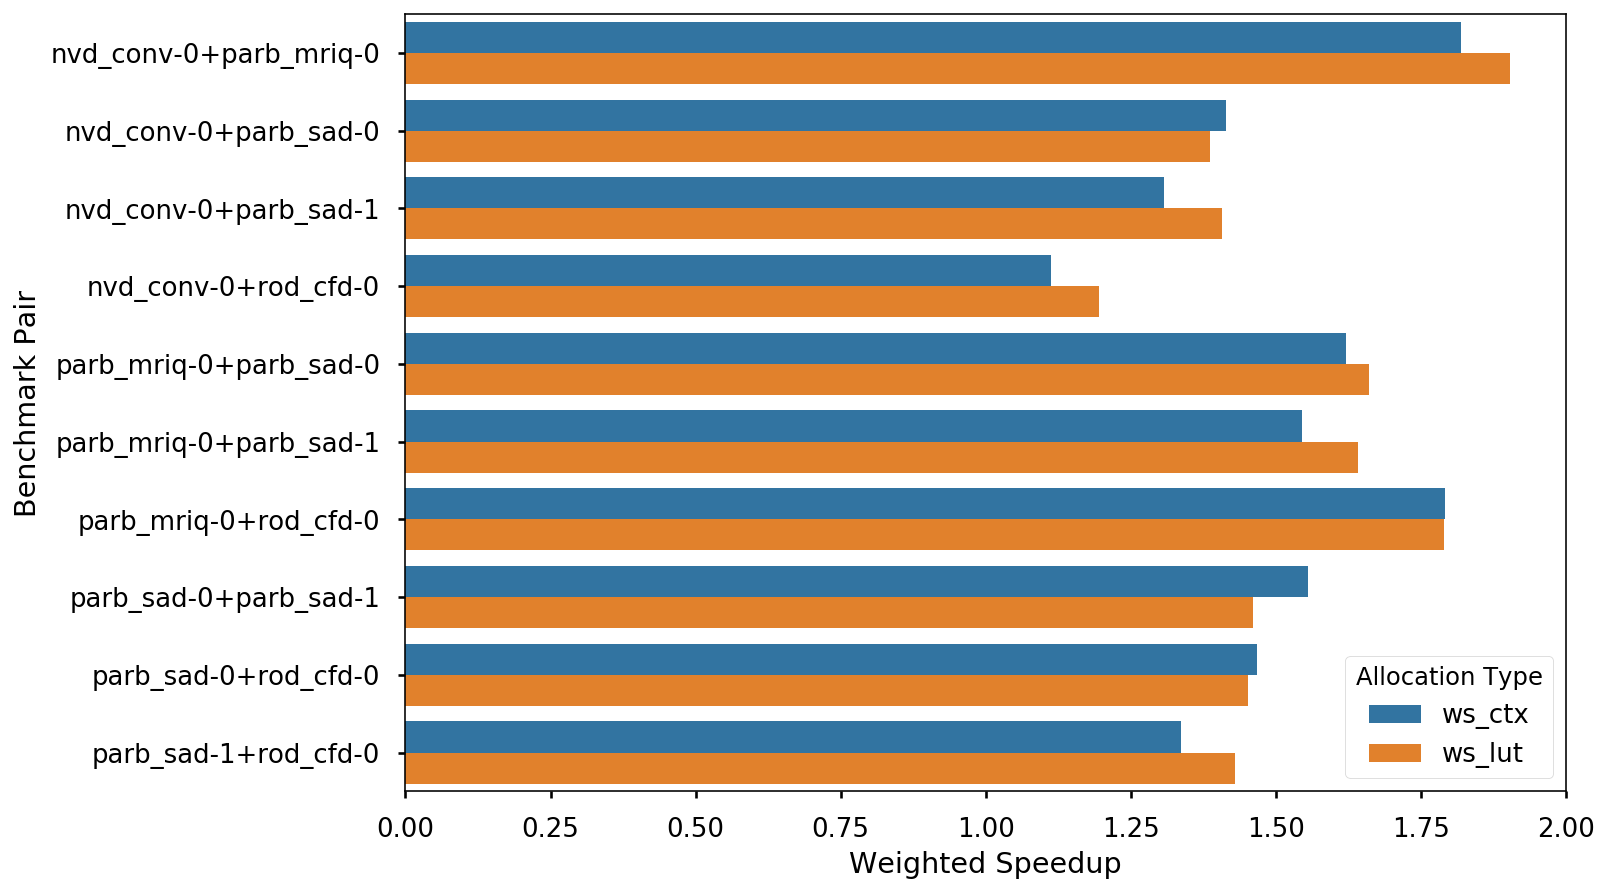

In [94]:
df_lut_ctx['Benchmark Pair'] = df_lut_ctx.apply(lambda row: "{}+{}".format(row['1_bench'], row['2_bench']), axis = 1) 
df_lut_ctx_long = pd.melt(df_lut_ctx[['Benchmark Pair', 'ws_lut', 'ws_ctx']], id_vars=['Benchmark Pair'], value_vars=['ws_lut', 'ws_ctx'], var_name='Allocation Type').sort_values(['Benchmark Pair'])

sns.barplot(y='Benchmark Pair', x='value', hue='Allocation Type', data=df_lut_ctx_long)
# plt.xticks(rotation=90)
plt.xlabel('Weighted Speedup')
plt.xlim([0, 2])

plt.show()